# Illustration of the diffusion_map class on the classic swiss roll data set

author: Ralf Banisch

We demonstrate the usage of the diffusion_map class on a two-dimensional manifold embedded in $\mathbb{R}^3$.


In [1]:
# import some necessary functions for plotting as well as the diffusion_map class from pydiffmap.

import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from pydiffmap import diffusion_map as dm

%matplotlib inline

## Create Data

We create the dataset: A noisy sampling of the twodimensional "swiss roll" embedded in $\mathbb{R}^3$. The sampling is such that the density of samples decreases with the distance from the origin (non-uniform sampling).

In order to be handled correctly by the diffusion_map class, we must ensure the data is a numpy array of shape (n_points, n_features).

In [2]:
# set parameters
length_phi = 15   #length of swiss roll in angular direction
length_Z = 15     #length of swiss roll in z direction
sigma = 0.1       #noise strength
m = 20000         #number of samples

# create dataset
phi = length_phi*np.random.rand(m)
xi = np.random.rand(m)
Z = length_Z*np.random.rand(m)
X = 1./6*(phi + sigma*xi)*np.sin(phi)
Y = 1./6*(phi + sigma*xi)*np.cos(phi)

swiss_roll = np.array([X, Y, Z]).transpose()

# check that we have the right shape
print(swiss_roll.shape)

(20000, 3)


## Run pydiffmap

Now we initialize the diffusion map object and fit it to the dataset. Since we are interested in only the first two diffusion coordinates we set n_evecs = 2, and since we want to unbias with respect to the non-uniform sampling density we set alpha = 1.0. The epsilon parameter controls the scale and needs to be adjusted to the data at hand. The k parameter controls the neighbour lists, a smaller k will increase performance but decrease accuracy.

In [3]:
# initialize Diffusion map object.
mydmap = dm.DiffusionMap(n_evecs = 2, epsilon = .1, alpha = 1.0, k=200)
# fit to data and return the diffusion map.
dmap = mydmap.fit_transform(swiss_roll)

## Visualization

We show the original data set on the right, with points colored according to the first diffusion coordinate. On the left, we show the diffusion map embedding given by the first two diffusion coordinates. Points are again colored according to the first diffusion coordinate, which seems to parameterize the $\phi$ direction. We can see that the diffusion map embedding 'unwinds' the swiss roll.

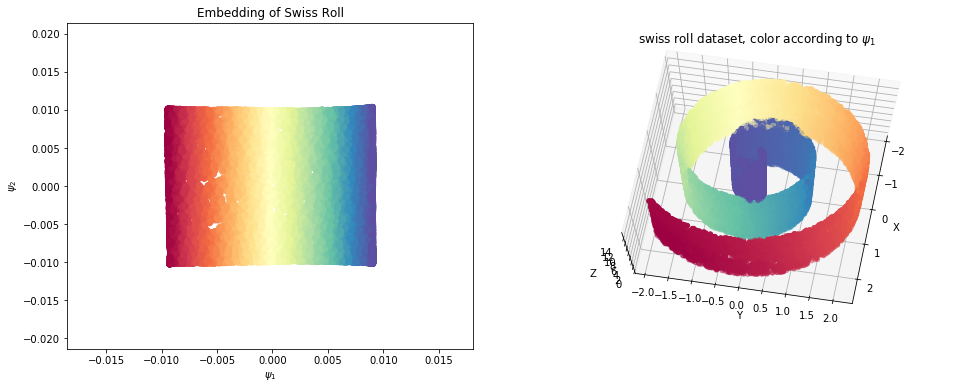

In [4]:
plt.figure(figsize=(16,6))
ax = plt.subplot(121)
ax.scatter(dmap[:,0],dmap[:,1], c=dmap[:,0], cmap=plt.cm.Spectral)
ax.set_title('Embedding of Swiss Roll')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.axis('tight')

ax2 = plt.subplot(122,projection='3d')
ax2.scatter(X,Y,Z, c=dmap[:,0], cmap=plt.cm.Spectral)
ax2.view_init(75, 10)
ax2.set_title('swiss roll dataset, color according to $\psi_1$')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

To get a bit more information out of the embedding, we can scale the points according to the numerical estimate of the sampling density (mydmap.q), and color them according to their location in the phi direction. For comparison, we color the original data set according to $\phi$ this time.

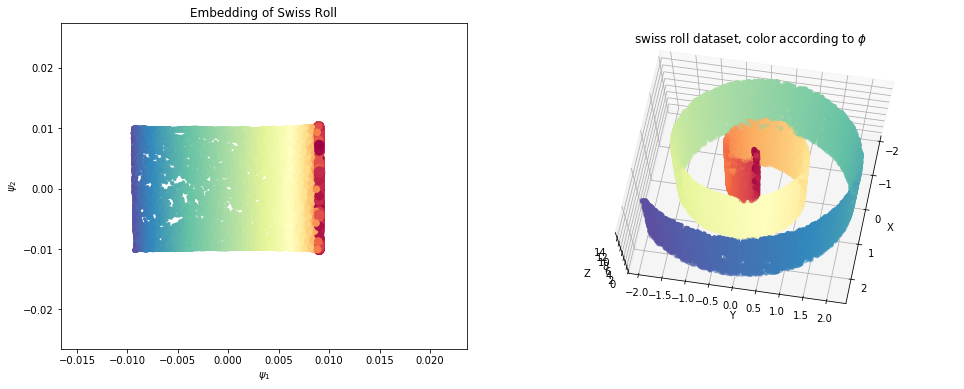

In [5]:
plt.figure(figsize=(16,6))
ax = plt.subplot(121)
ax.scatter(dmap[:,0],dmap[:,1], s=mydmap.q, c=phi, cmap=plt.cm.Spectral)
ax.set_title('Embedding of Swiss Roll')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.axis('tight')

ax2 = plt.subplot(122,projection='3d')
ax2.scatter(X,Y,Z, c=phi, cmap=plt.cm.Spectral)
ax2.view_init(75, 10)
ax2.set_title('swiss roll dataset, color according to $\phi$')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

We can see that points near the center of the swiss roll, where the winding is tight, are closer together in the embedding, while points further away from the center are more spaced out. Let's check how the first two diffusion coordinates correlate with $\phi$ and $Z$.

Correlation between \phi and \psi_1
[[ 1.         -0.93720152]
 [-0.93720152  1.        ]]
Correlation between Z and \psi_2
[[ 1.         -0.99287851]
 [-0.99287851  1.        ]]


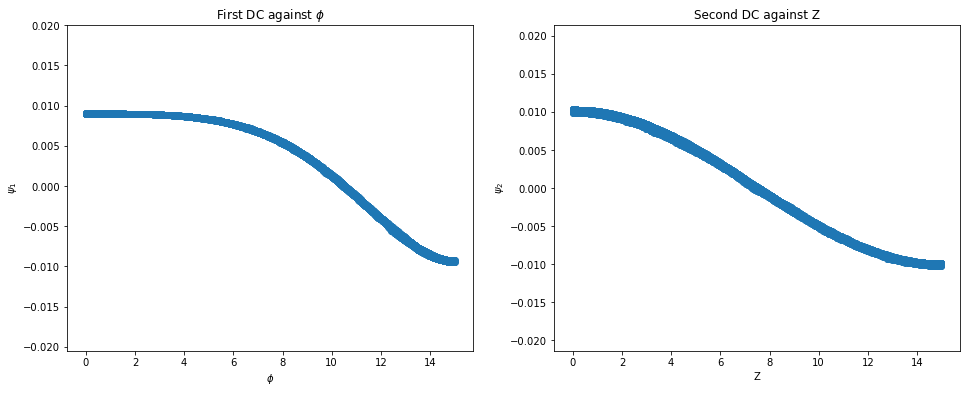

In [6]:
print('Correlation between \phi and \psi_1')
print(np.corrcoef(dmap[:,0], phi))

plt.figure(figsize=(16,6))
ax = plt.subplot(121)
ax.scatter(phi, dmap[:,0])
ax.set_title('First DC against $\phi$')
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\psi_1$')
ax.axis('tight')

print('Correlation between Z and \psi_2')
print(np.corrcoef(dmap[:,1], Z))

ax2 = plt.subplot(122)
ax2.scatter(Z, dmap[:,1])
ax2.set_title('Second DC against Z')
ax2.set_xlabel('Z')
ax2.set_ylabel(r'$\psi_2$')

plt.show()

## Landmarks, standalone KDE implementation

In [113]:
from pydiffmap import kernel as kernel
import scipy.sparse.linalg as spsl
#import scipy.sparse as sps

def kde_landmarks(X, epsilon = 1.0, n_landmarks = 100, sparse_coeff = 0.5, method = 'random'):
    m = np.shape(X)[0]
    if (method=='random'):
        # choose some landmarks at random
        landmarks = np.random.choice(m, size = n_landmarks, replace = False)
    else:
        raise NotImplementedError('no other method for choosing landmarks implemented yet!')
    X_l = X[landmarks,:]
    #non-landmarks
    mask = np.ones(m,dtype=bool)
    mask[landmarks] = False
    #compute kernel K(X_l, X)
    my_kernel = kernel.Kernel(type='gaussian', epsilon=epsilon, k=n_landmarks).fit(X_l)
    Q_J = my_kernel.compute(X_l)
    Q_J = 0.5*(Q_J + Q_J.transpose())
    my_kernel = kernel.Kernel(type='gaussian', epsilon=epsilon, k=np.int(m*sparse_coeff)).fit(X[mask])
    Y = my_kernel.compute(X_l)
    # compute kde
    q_landmarks = np.array(Q_J.sum(axis=1)).ravel() + np.array(Y.sum(axis=1)).ravel()
    q_mask = Y.sum(axis=0) + Y.transpose() * spsl.spsolve(Q_J,Y.sum(axis=1))
    q_mask = np.array(q_mask).ravel()
    # prepare output
    q = np.ones(m,dtype=float)
    q[landmarks] = q_landmarks
    q[mask] = q_mask
        
    return q

In [114]:
q = kde_landmarks(swiss_roll, epsilon = 1.0, n_landmarks = 500, method='random')

In [115]:
#K_full = my_kernel.compute(X)
#q_full = np.array(K_full.sum(axis=1)).ravel()

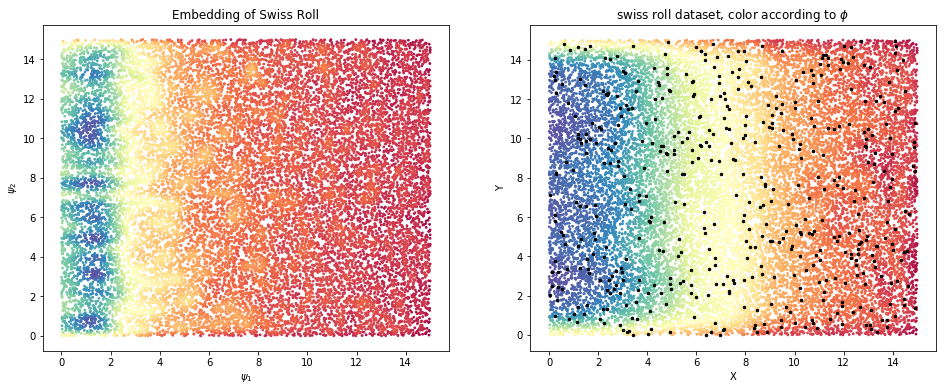

In [116]:
plt.figure(figsize=(16,6))
ax = plt.subplot(121)
ax.scatter(phi,Z, s = 3,c=mydmap.q, cmap=plt.cm.Spectral)#
ax.set_title('Embedding of Swiss Roll')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.axis('tight')

ax2 = plt.subplot(122)
ax2.scatter(phi, Z, s= 3, c=q, cmap=plt.cm.Spectral)
ax2.scatter(phi[landmarks], Z[landmarks], s= 6, c='k')
ax2.set_title('swiss roll dataset, color according to $\phi$')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

plt.show()

## Test Landmark functionality in pydiffmap

In [40]:
import imp
imp.reload(dm)

# initialize Diffusion map object.
mydmap_lm = dm.LandmarkDiffusionMap(n_evecs = 2, epsilon = 0.1, alpha = 1.0, k=200)
# fit to data and return the diffusion map.
mydmap_lm.fit(swiss_roll, method = 'poisson_disk', n_landmarks = 1000)

In [41]:
mydmap_lm.epsilon_fitted

0.1

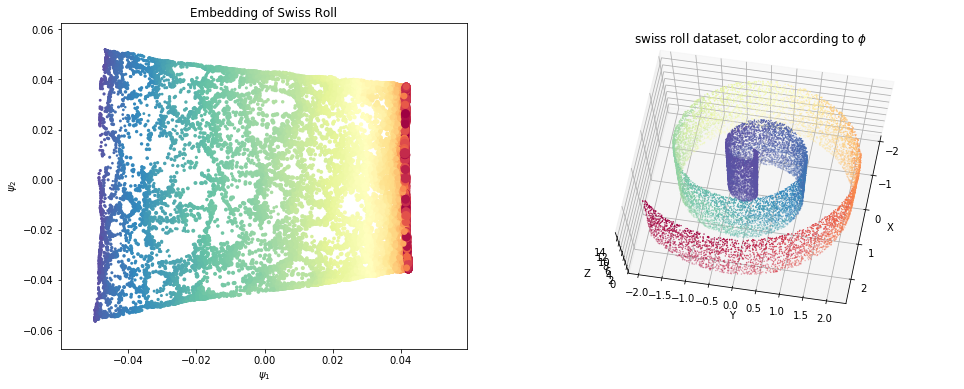

In [42]:
plt.figure(figsize=(16,6))
ax = plt.subplot(121)
ax.scatter(mydmap_lm.dmap[:,0],mydmap_lm.dmap[:,1], s=mydmap.q, c=phi, cmap=plt.cm.Spectral, linewidths=0)
ax.set_title('Embedding of Swiss Roll')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.axis('tight')

ax2 = plt.subplot(122,projection='3d')
#ax2.scatter(mydmap_lm.data[:,0],mydmap_lm.data[:,1],mydmap_lm.data[:,2], c='k', s=20)
ax2.scatter(X,Y,Z, c=mydmap_lm.dmap[:,0], cmap=plt.cm.Spectral, s = 2, linewidths=0)
ax2.view_init(75, 10)
ax2.set_title('swiss roll dataset, color according to $\phi$')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

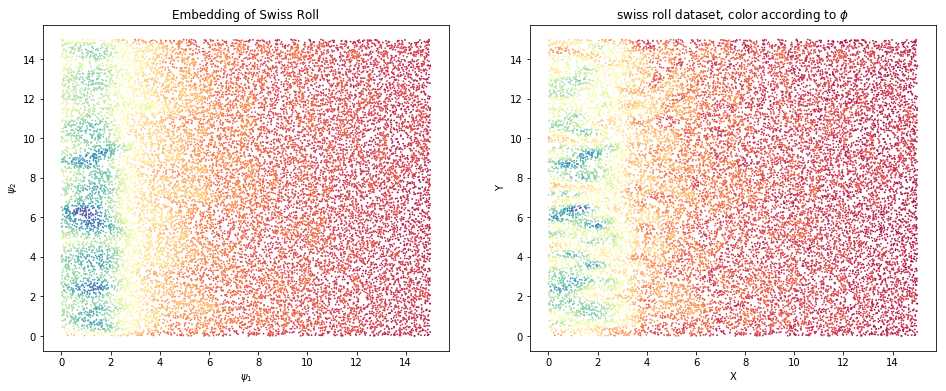

In [43]:
plt.figure(figsize=(16,6))
ax = plt.subplot(121)
ax.scatter(phi,Z, s = 3,c=mydmap.q, cmap=plt.cm.Spectral, linewidths=0)#
ax.set_title('Embedding of Swiss Roll')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.axis('tight')

ax2 = plt.subplot(122)
ax2.scatter(phi, Z, s= 3, c=mydmap_lm.q, cmap=plt.cm.Spectral, linewidths=0)
#ax2.scatter(phi[landmarks], Z[landmarks], s= 6, c='k')
ax2.set_title('swiss roll dataset, color according to $\phi$')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

plt.show()

## clustering

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=1000, max_iter=10, n_init = 1).fit(swiss_roll)

In [19]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1).fit(swiss_roll)
distances, indices = nbrs.kneighbors(kmeans.cluster_centers_)
landmarks = indices.ravel()

(-0.75244415526258468,
 15.762787548683345,
 -0.75167463082471098,
 15.753602081659546)

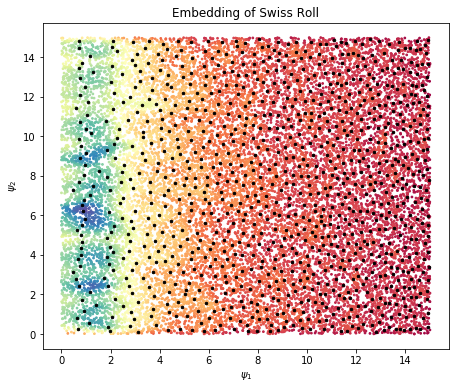

In [20]:
plt.figure(figsize=(16,6))
ax = plt.subplot(121)
ax.scatter(phi,Z, s = 3,c=mydmap.q, cmap=plt.cm.Spectral)
ax.scatter(phi[landmarks],Z[landmarks], s = 6,c='k')
ax.set_title('Embedding of Swiss Roll')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.axis('tight')

In [23]:
from scipy.spatial.distance import cdist

def picking(data, n_samples):
    # select a random point and compute distances to it
    m = np.shape(data)[0]
    idx_corner = np.random.randint(m)

    dist = cdist(data[[idx_corner],:], data)[0]

    # find first cornerstone
    idx_corner = [np.argmax(dist)]
    # print('idx_corner ')
    # print(idx_corner)
    # iteration to find the other cornerstones
    for k in np.arange(1, n_samples):
        # update minimum distance to existing cornerstones
        if(k>1):
            dist = np.minimum(dist, cdist(data[[idx_corner[-1]],:], data)[0])
        else:
            dist = cdist(data[idx_corner,:], data)[0]
        # select new cornerstone
        idx_corner.append(np.argmax(dist))
    return idx_corner


In [29]:
landmarks = picking(swiss_roll, 500)

(-0.75417158521320538,
 15.799063577646381,
 -0.81598769501623758,
 15.811859950332856)

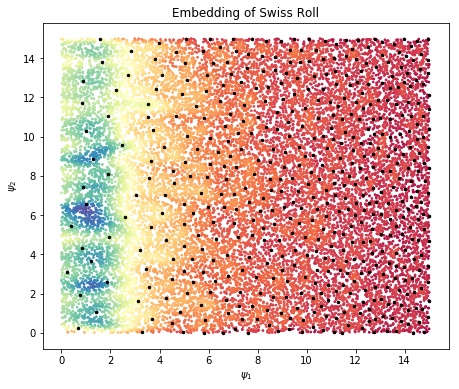

In [30]:
plt.figure(figsize=(16,6))
ax = plt.subplot(121)
ax.scatter(phi,Z, s = 3,c=mydmap.q, cmap=plt.cm.Spectral)
ax.scatter(phi[landmarks],Z[landmarks], s = 6,c='k')
ax.set_title('Embedding of Swiss Roll')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.axis('tight')